In [3]:
import torch
print(torch.__version__)  # 打印 PyTorch 版本
print(torch.cuda.is_available())  # 检查 CUDA 是否可用
print(torch.version.cuda)  # 打印 PyTorch 使用的 CUDA 版本

2.6.0+cu118
True
11.8


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}", torch.cuda.is_available())

Using device: cuda True


In [7]:
import torch.nn as nn
import torch.optim as optim
import scipy.io
import numpy as np
import time
import matplotlib.pyplot as plt

In [9]:
b_vec = torch.tensor([[0.0],[1.0]], dtype = torch.float32)

In [11]:
class StateNetwork(nn.Module):
	def __init__(self, hidden_dim=32):
		super(StateNetwork, self).__init__()
		self.net = nn.Sequential(
			nn.Linear(1, hidden_dim),
			nn.Tanh(),
			nn.Linear(hidden_dim, hidden_dim),
			nn.Tanh(),
			nn.Linear(hidden_dim,2)
		)
		
	def forward(self, t):
		return self.net(t)
		

In [19]:
q_net = StateNetwork(hidden_dim=32)

alpha0 = torch.nn.Parameter(torch.tensor([0.0], dtype=torch.float32))
alpha1 = torch.nn.Parameter(torch.tensor([0.0], dtype=torch.float32))

c_vec = torch.nn.Parameter(torch.zeros(2, dtype=torch.float32))
d = torch.nn.Parameter(torch.tensor(0.0, dtype = torch.float32))

params = list(q_net.parameters())+[alpha0, alpha1, c_vec, d]


In [35]:
def load_data():
	data = scipy.io.loadmat('wave_1d_impedance250124.mat')
	pfield = torch.tensor(data['P'], dtype=torch.float32)
	ufield = torch.tensor(data['U'], dtype = torch.float32)
	c_in = torch.tensor(data['c'], dtype=torch.float32)
	#DUDX = torch.tensor(data['DUDX'], dtype=torch.float32)
	dx = data['dx'][0][0]
	dt = data['dt'][0][0]
	
	t = dt*torch.linspace(0,499,500, requires_grad=True)
	t = t.flatten().unsqueeze(1)
	u_known = ufield.flatten().unsqueeze(1)
	p_known = pfield.flatten().unsqueeze(1)
	c_known = c_in.to(device)
	return t, u_known, p_known#, DUDX

In [37]:
t, u_known, p_known = load_data()
print(t.shape,p_known.shape)

torch.Size([500, 1]) torch.Size([50500, 1])


Text(0.5, 1.0, 'u')

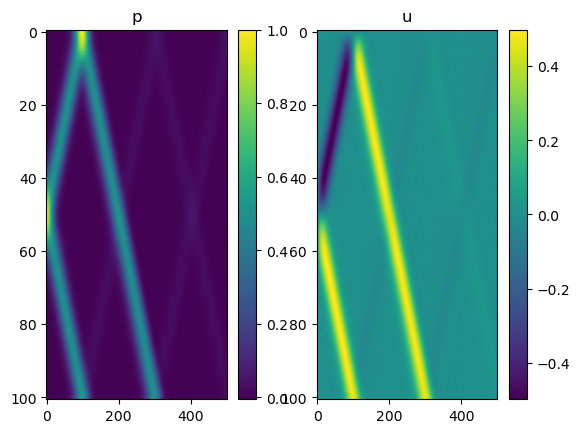

In [39]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(p_known.numpy().reshape((101,500)), aspect='auto')
plt.colorbar()
plt.title('p')
plt.subplot(1,2,2)
plt.imshow(u_known.numpy().reshape((101,500)), aspect='auto')
plt.colorbar()
plt.title('u')

Text(0.5, 1.0, 'u')

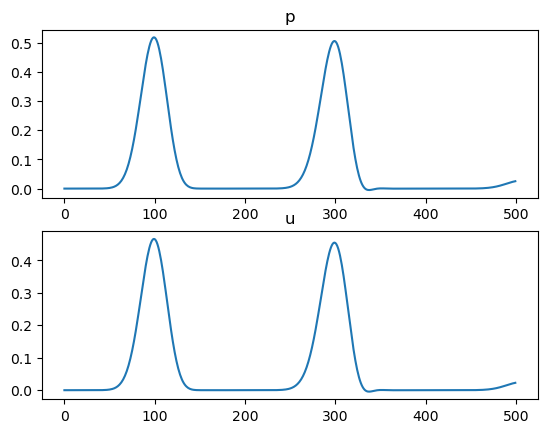

In [41]:
p_mat = p_known.numpy().reshape((101,500))
pL_data = p_mat[-1,:]
pL_data = torch.from_numpy(pL_data).unsqueeze(1)
u_mat = u_known.numpy().reshape((101,500))
uL_data = u_mat[-1,:]
uL_data = torch.from_numpy(uL_data).unsqueeze(1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(pL_data)
plt.title('p')
plt.subplot(2,1,2)
plt.plot(uL_data)
plt.title('u')

In [43]:
uL_data.shape

torch.Size([500, 1])

In [45]:
t_data = t
t_data.shape

torch.Size([500, 1])

In [80]:
def model_loss(t_in, pL_in, ul_true):
    q_pred = q_net(t_in)
    t_in_reqgrad = t_in.clone().detach().requires_grad_(True)
    q_pred_reqgrad = q_net(t_in_reqgrad)
	
    q_dot_list = []
    for i_dim in range(2):
    	q_i = q_pred_reqgrad[:,i_dim].unsqueeze(1)
    	dq_i_dt = torch.autograd.grad(q_i, t_in_reqgrad, grad_outputs = torch.ones_like(q_i), retain_graph=True, create_graph=True)[0]
    	q_dot_list.append(dq_i_dt)
        
    q_dot_pred = torch.cat(q_dot_list, dim=1)
	
    A00 = torch.tensor(0.0, dtype = torch.float32, device = alpha0.device)
    A01 = torch.tensor(1.0, dtype = torch.float32, device = alpha0.device)
    A10 = alpha0
    A11 = alpha1
    
    q1 = q_pred[:,0:1]
    q2 = q_pred[:,1:2]
    Aq_0 = A00*q1 + A01*q2
    Aq_1 = A10*q1 + A11*q2
    Aq_pred = torch.cat([Aq_0,Aq_1], dim=1)
    
    b_term = torch.cat([torch.zeros_like(pL_data), pL_data], dim=1)
    rhs = Aq_pred + b_term
    
    physics_loss = torch.mean((q_dot_pred - rhs)**2)
    
    c_vec_resh = c_vec.unsqueeze(0)
    u_from_q = torch.sum(c_vec_resh*q_pred, dim=1, keepdim=True)
    u_pred = u_from_q + d*pL_in
    
    data_loss = torch.mean((u_pred - ul_true)**2)
    return physics_loss, data_loss

In [ ]:
lr=1e-3
optimizer = torch.optim.Adam(params, lr=lr)

num_epochs = 10000
lambda_phys = 1
lambda_data = 1

losses_U=[]
losses_F=[]
losses_total=[]
A0=[]
A1=[]
C0=[]
C1=[]
D=[]

start_time = time.time()
for epoch in range(num_epochs):
	optimizer.zero_grad()
	phys_loss, dat_loss = model_loss(t_data, pL_data, uL_data)
	loss = lambda_phys*phys_loss + lambda_data*dat_loss
	
	loss.backward(retain_graph=True)
	optimizer.step()
	
	losses_total.append(loss.item())
	losses_U.append(dat_loss.item())
	losses_F.append(phys_loss.item())
	A0.append(alpha0.item())
	A1.append(alpha1.item())
	C0.append(c_vec[0].item())
	C1.append(c_vec[1].item())
	D.append(d.item)

	if epoch%10==0:
		stop_time = time.time()
		e_time = stop_time-start_time
		print(f"Epoch {epoch}, loss={loss.item():.6g}, phys={phys_loss.item():.5g}, data={dat_loss.item():.5g}, a0={alpha0.item():.4g}, a1={alpha1.item():.4g}, c0={c_vec[0].item():.4g}, c1={c_vec[1].item():.4g}, d={d.item():.4g}, time={e_time:.4g}")
		start_time = time.time()
		
loss_arr_total = np.array(losses_total)
loss_arr_U = np.array(losses_U)
loss_arr_F = np.array(losses_F)
A0_arr = np.array(A0)
A1_arr = np.array(A1)
C0_arr = np.array(C0)
C1_arr = np.array(C1)
D_arr = np.array(D)

try:
	np.savez('losses_archiveImp.npz', losses_total=loss_arr_total, losses_U = loss_arr_U, losses_F=loss_arr_F, A0=A0_arr, A1 = A1_arr, C0=C0_arr, C1=C1_arr, D=D_arr)
	print('Losses saved successfully')
except Exception as e:
	print(f'An error occured: {e}')